# Part 1: DeBERTa + LoRA Fine-Tuning and Saving

This notebook fine-tunes a DeBERTa-small model using LoRA and saves the resulting adapter model weights.

## 2. Load and Prepare Data

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import pandas as pd
import numpy as np
import torch
from datasets import load_dataset, ClassLabel, Value
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig
from transformers import BitsAndBytesConfig

# 1. [변경] 'datasets'로 CSV 로드 (RAM에 올리지 않음)
path = './dataset/'
raw_dataset = load_dataset('csv', data_files=path + 'train.csv')

# 2. 이 코드에서 안넘어감..
model_name = 'microsoft/deberta-v3-small'
tokenizer = AutoTokenizer.from_pretrained(model_name)

print('!@#%$%^&!@#$')

def preprocess_function(examples):
    # 레이블 생성 (handle batched input)
    conditions = [(np.array(examples['winner_model_a']) == 1), (np.array(examples['winner_model_b']) == 1), (np.array(examples['winner_tie']) == 1)]
    choices = [0, 1, 2]
    examples['labels'] = np.select(conditions, choices, default=-1).tolist()

    # 텍스트 생성 (handle batched input)
    examples['text'] = [("prompt: " + prompt +
                        "\n\nresponse_a: " + response_a +
                        "\n\nresponse_b: " + response_b) for prompt, response_a, response_b in zip(examples['prompt'], examples['response_a'], examples['response_b'])]

    # 토큰화 (여기서 max_length가 중요)
    tokenized_inputs = tokenizer(examples['text'], truncation=True, padding="max_length", max_length=1536)

    # 토okenization results are already batched, just add the 'labels'
    tokenized_inputs['labels'] = examples['labels']

    # Return only necessary columns
    return tokenized_inputs


# 3. [변경] .map()으로 전처리 적용 (배치로 처리되어 빠르고 RAM 절약)
# batched=True가 핵심입니다.
tokenized_dataset = raw_dataset.map(preprocess_function, batched=True)

# 4. [변경] 불필요한 원본 컬럼 제거 (필수!)
# 'label' -> 'labels'로 이름이 바뀌었으므로 원본 'label'도 제거
tokenized_dataset = tokenized_dataset['train'].remove_columns([
    'prompt', 'response_a', 'response_b', 'text',
    'winner_model_a', 'winner_model_b', 'winner_tie' # 'label' is not in the original csv columns
])

# 5. [변경] 유효하지 않은 레이블(-1) 필터링
tokenized_dataset = tokenized_dataset.filter(lambda example: example['labels'] != -1)


Generating train split: 57477 examples [00:01, 51169.53 examples/s]
C:\Users\keiro\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\keiro\.cache\huggingface\hub\models--microsoft--deberta-v3-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for thi

!@#%$%^&!@#$


Filter: 100%|████████████████████████████████████████████████████████████| 57477/57477 [01:08<00:00, 838.67 examples/s]


In [3]:
from datasets import load_dataset, ClassLabel, Value

# Cast 'labels' column to ClassLabel for stratification
tokenized_dataset = tokenized_dataset.cast_column("labels", ClassLabel(num_classes=3))

# 6. [변경] 데이터셋 분할
final_datasets = tokenized_dataset.train_test_split(test_size=0.2, stratify_by_column="labels")

# (참고) 이제 더 이상 수동으로 PreferenceDataset을 만들 필요가 없습니다!
train_dataset = final_datasets["train"]
val_dataset = final_datasets["test"]

Casting the dataset: 100%|████████████████████████████████████████████| 57477/57477 [00:00<00:00, 128553.30 examples/s]


## 3. Tokenization

## 4. LoRA Fine-Tuning

In [5]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig
import torch

# --- 기본 설정 ---
model_name = "microsoft/deberta-v3-small"
device = "cuda" if torch.cuda.is_available() else "cpu"

# bf16 가능한 GPU(암페어↑)면 bf16, 아니면 fp16 켜기 (CPU면 둘 다 False)
use_bf16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
use_fp16 = torch.cuda.is_available() and not use_bf16  # bf16 못 쓰면 fp16 시도

# --- 모델 로드: device_map='auto' 제거, 직접 GPU로 이동 ---
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    # device_map="auto"  # ❌ 지원 안 해서 제거
)
model.to(device)  # ✅ 전체를 GPU로 올림 (또는 CPU)

# --- LoRA 설정/적용 ---
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query_proj", "value_proj"],  # 필요시 ["query_proj","key_proj","value_proj","o_proj"]
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS",
)
lora_model = get_peft_model(model, lora_config)
lora_model.to(device)

# (선택) 학습 가능한 파라미터 수 확인
def print_trainable_parameters(m):
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    total = sum(p.numel() for p in m.parameters())
    print(f"Trainable params: {trainable:,} / {total:,} ({100 * trainable/total:.2f}%)")
print_trainable_parameters(lora_model)

# --- TrainingArguments ---
training_args = TrainingArguments(
    output_dir="./results_lora",
    num_train_epochs=1,
    per_device_train_batch_size=4,          # 메모리 부족하면 2 또는 1로
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=1,          # 메모리 아끼려면 4~8로 올리기
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="steps",            # ✅ 올바른 인자명
    eval_steps=5000,
    logging_dir="./logs_lora",
    logging_steps=100,
    save_steps=5000,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none",
    fp16=use_fp16,                          # CUDA + bf16 미지원이면 fp16
    bf16=use_bf16,                          # CUDA + bf16 지원이면 bf16
)

# ⚠️ 주의: 아래 두 개는 이미 준비돼 있다고 가정합니다.
# train_dataset, val_dataset

trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\keiro\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainable params: 297,219 / 142,194,438 (0.21%)


Step,Training Loss,Validation Loss
5000,1.090100,1.086369
10000,1.099500,1.083562


TrainOutput(global_step=11496, training_loss=1.0911426637101356, metrics={'train_runtime': 5939.3271, 'train_samples_per_second': 7.742, 'train_steps_per_second': 1.936, 'total_flos': 1.839987693141811e+16, 'train_loss': 1.0911426637101356, 'epoch': 1.0})

## 5. Save LoRA Model Adapters

In [6]:
model_save_path = 'deberta_lora_model'
lora_model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path) # Save tokenizer with the adapters

print(f"LoRA model adapters saved to {model_save_path}")

LoRA model adapters saved to deberta_lora_model


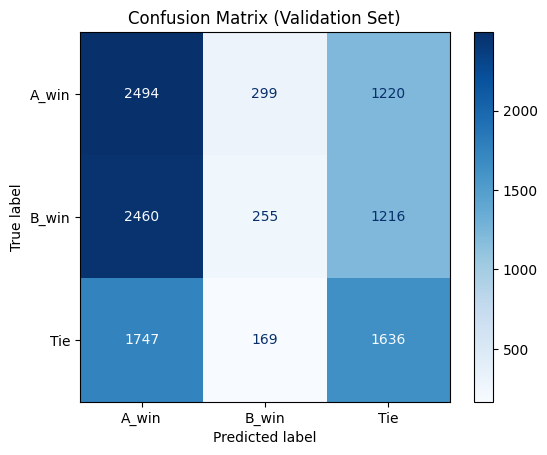


Classification Report (Validation Set):

              precision    recall  f1-score   support

       A_win       0.37      0.62      0.47      4013
       B_win       0.35      0.06      0.11      3931
         Tie       0.40      0.46      0.43      3552

    accuracy                           0.38     11496
   macro avg       0.38      0.38      0.33     11496
weighted avg       0.37      0.38      0.33     11496



In [12]:
predictions_output = trainer.predict(val_dataset)

# 2. 예측 결과에서 로짓(logits)과 실제 레이블 추출
# predictions_output.predictions는 (샘플 수, 3) 모양의 로짓 배열입니다.
logits = predictions_output.predictions
# predictions_output.label_ids는 실제 정답 레이블입니다.
y_true = predictions_output.label_ids

# 3. 로짓을 argmax를 통해 최종 예측 레이블(0, 1, 2)로 변환
y_pred = np.argmax(logits, axis=1)

# --- (여기부터는 Confusion Matrix를 그리는 표준 코드) ---

# 4. Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred)

# (이전 대화에서 사용한 레이블 이름)
labels = ["A_win", "B_win", "Tie"] 

# 5. Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Validation Set)")
plt.show()

# 6. (보너스) F1-score 등 상세 리포트 출력
print("\nClassification Report (Validation Set):\n")
print(classification_report(y_true, y_pred, target_names=labels))

C:\Users\keiro\AppData\Roaming\Python\Python312\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Casting the dataset: 100%|████████████████████████████████████████████| 57477/57477 [00:00<00:00, 148101.47 examples/s]
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_

… Starting LoRA training (Approx. Actual Batch Size: 8) …


Step,Training Loss,Validation Loss
200,No log,1.099542
400,No log,1.098762
600,1.101900,1.097937
800,1.101900,1.095994
1000,1.099300,1.095564
1200,1.099300,1.094148
1400,1.099300,1.092414
1600,1.095900,1.093487
1800,1.095900,1.091830
2000,1.096500,1.090026


… Training Complete. Loading best model for evaluation …


<Figure size 800x600 with 0 Axes>

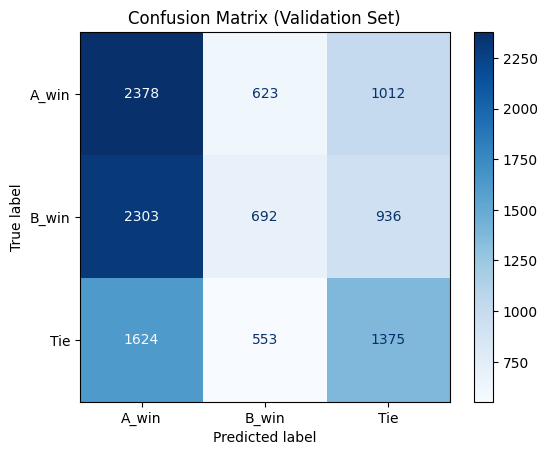


Classification Report (Validation Set):

              precision    recall  f1-score   support

       A_win       0.38      0.59      0.46      4013
       B_win       0.37      0.18      0.24      3931
         Tie       0.41      0.39      0.40      3552

    accuracy                           0.39     11496
   macro avg       0.39      0.39      0.37     11496
weighted avg       0.39      0.39      0.37     11496



In [15]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from datasets import load_dataset, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig

# --- 환경 설정 ---
model_name = 'microsoft/deberta-v3-small'
MAX_LENGTH = 512 # 메모리 최적화를 위해 시퀀스 길이 512 유지
EVAL_STEPS = 200 
SAVE_STEPS = 200 
LABELS = ["A_win", "B_win", "Tie"] # 혼동 행렬에 사용할 레이블

# GPU 환경 확인 및 dtype 설정 (bf16이 가능한지 확인)
if torch.cuda.is_available() and torch.cuda.get_device_properties(0).major >= 8:
    DTYPE = torch.bfloat16
    FP16_FLAG = False
    BF16_FLAG = True
else:
    DTYPE = torch.float16
    FP16_FLAG = True
    BF16_FLAG = False

# 1. 데이터 로드 및 토크나이저 초기화
path = './dataset/'
raw_dataset = load_dataset('csv', data_files=path + 'train.csv')
tokenizer = AutoTokenizer.from_pretrained(model_name)

# --- 전처리 함수 ---
def preprocess_function(examples):
    conditions = [(np.array(examples['winner_model_a']) == 1), (np.array(examples['winner_model_b']) == 1), (np.array(examples['winner_tie']) == 1)]
    choices = [0, 1, 2]
    examples['labels'] = np.select(conditions, choices, default=-1).tolist()
    
    # 텍스트 생성: [SEP] 토큰 사용으로 A/B 응답 구분 명확히
    examples['text'] = [
        (prompt + tokenizer.sep_token + response_a + tokenizer.sep_token + response_b)
        for prompt, response_a, response_b in zip(examples['prompt'], examples['response_a'], examples['response_b'])
    ]
    
    tokenized_inputs = tokenizer(examples['text'], truncation=True, padding="max_length", max_length=MAX_LENGTH)
    tokenized_inputs['labels'] = examples['labels']
    return tokenized_inputs

# 2. 전처리 적용 및 데이터셋 분할
tokenized_dataset = raw_dataset.map(preprocess_function, batched=True)
tokenized_dataset = tokenized_dataset['train'].remove_columns([
    'prompt', 'response_a', 'response_b', 
    'winner_model_a', 'winner_model_b', 'winner_tie' 
])
tokenized_dataset = tokenized_dataset.filter(lambda example: example['labels'] != -1)
tokenized_dataset = tokenized_dataset.cast_column("labels", ClassLabel(num_classes=3))

final_datasets = tokenized_dataset.train_test_split(test_size=0.2, stratify_by_column="labels", seed=42)
train_dataset = final_datasets["train"]
val_dataset = final_datasets["test"]

# 3. 모델 로드 및 LoRA 적용
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    # device_map='auto', <— 오류를 일으킨 부분 제거
    torch_dtype=DTYPE
)

# — LoRA 파라미터 튜닝 —
lora_config = LoraConfig(
    r=32,                  # 🚨 Rank(r)를 16에서 32로 증가 (더 많은 파라미터 학습 가능)
    lora_alpha=64,         # lora_alpha를 r의 2배로 증가
    target_modules=['query_proj', 'value_proj'],
    lora_dropout=0.1,      # Dropout을 0.1로 증가 (과적합 방지 시도)
    bias='none', 
    task_type="SEQ_CLS"
)
lora_model = get_peft_model(model, lora_config)

# 4. Training Arguments 설정
training_args = TrainingArguments(
    output_dir='./results_lora_optimized', 
    num_train_epochs=3, 
    learning_rate=3e-5,    # 🚨 Learning Rate를 3e-5로 명시 (LoRA 최적 LR)
    per_device_train_batch_size=2, 
    gradient_accumulation_steps=4, 
    fp16=FP16_FLAG, 
    bf16=BF16_FLAG, 
    per_device_eval_batch_size=4, 
    warmup_steps=500, 
    weight_decay=0.01,
    logging_dir='./logs_lora_optimized', 
    eval_strategy="steps", 
    eval_steps=EVAL_STEPS, 
    save_steps=SAVE_STEPS, 
    load_best_model_at_end=True,
    report_to="none"
)

# 5. 학습 시작
trainer = Trainer(model=lora_model, args=training_args, train_dataset=train_dataset, eval_dataset=val_dataset)
print("… Starting LoRA training (Approx. Actual Batch Size: 8) …")
trainer.train()
print("… Training Complete. Loading best model for evaluation …")

# 6. Confusion Matrix 계산 및 출력
predictions = trainer.predict(val_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred)

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Validation Set)")
plt.show()

# 상세 리포트 출력
print("\nClassification Report (Validation Set):\n")
print(classification_report(y_true, y_pred, target_names=LABELS))

In [16]:
model_save_path = 'deberta_lora_model2'
lora_model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path) # Save tokenizer with the adapters

print(f"LoRA model adapters saved to {model_save_path}")

LoRA model adapters saved to deberta_lora_model2


In [18]:
# (이전 셀에서 y_true, y_pred, raw_dataset, ClassLabel이 정의되었다고 가정)


# 1. 레이블만 생성하는 간단한 전처리 함수
def add_labels_only(example):
    # .map()의 새 프로세스를 위해 numpy 임포트
    import numpy as np

    if example["winner_model_a"] == 1:
        example["labels"] = 0
    elif example["winner_model_b"] == 1:
        example["labels"] = 1
    elif example["winner_tie"] == 1:
        example["labels"] = 2
    else:
        example["labels"] = -1
    return example


print("Re-creating validation set texts (this is fast)...")
# 2. 레이블 추가 (batched=False, num_proc=1)
dataset_with_labels = raw_dataset["train"].map(add_labels_only, num_proc=1)

# 3. -1 레이블 필터링
filtered_dataset = dataset_with_labels.filter(
    lambda example: example["labels"] != -1, num_proc=1
)

# 4. ClassLabel 캐스팅
casted_dataset = filtered_dataset.cast_column("labels", ClassLabel(num_classes=3))

# 5. (중요) 훈련 때와 *똑같은* 시드와 비율로 스플릿
# (seed=42, test_size=0.2, stratify_by_column="labels")
temp_final_datasets = casted_dataset.train_test_split(
    test_size=0.2, stratify_by_column="labels", seed=42
)

# 6. 원본 텍스트가 포함된 validation set 확보
# 이 데이터셋은 y_true, y_pred 배열과 순서가 1:1로 일치합니다.
val_texts_dataset = temp_final_datasets["test"]
print("Validation texts recreated.")

# 7. Pandas로 변환하여 분석
df_report = pd.DataFrame(val_texts_dataset)
df_report["pred_label"] = y_pred
df_report["true_label"] = y_true

# 8. 틀린 것들만 필터링
df_errors = df_report[df_report["true_label"] != df_report["pred_label"]]

print(f"\n--- 😱 총 {len(df_errors)}개의 예측 오류 ---")

# 9. 레이블 이름 맵 (이전과 동일)
label_names = {0: "A_win (0)", 1: "B_win (1)", 2: "Tie (2)"}

# 10. 상위 10개의 오류만 출력
for index, row in df_errors.head(10).iterrows():
    print("=" * 40)
    print(f"오류 ID: {index}")
    print(f"    👉 정답 (True): {label_names[row['true_label']]}")
    print(f"    👉 예측 (Pred): {label_names[row['pred_label']]}")
    print("=" * 40)

    print("\n[Prompt]:")
    print(row["prompt"])

    print("\n[Response A]:")
    print(row["response_a"])

    print("\n[Response B]:")
    print(row["response_b"])
    print("\n" + "-" * 40 + "\n")

print(f"\n...(총 {len(df_errors)}개 오류 중 상위 10개만 출력)...")

# --- [추가] 11. 전체 오류 목록을 CSV 파일로 저장 ---
csv_filename = "prediction_errors.csv"
print(f"\n💾 모든 오류 내역을 {csv_filename} 파일로 저장 중...")
df_errors.to_csv(csv_filename, index=False, encoding="utf-8-sig")
print("저장 완료.")

Re-creating validation set texts (this is fast)...
Validation texts recreated.

--- 😱 총 7051개의 예측 오류 ---
오류 ID: 4
    👉 정답 (True): B_win (1)
    👉 예측 (Pred): Tie (2)

[Prompt]:
["How long should I wait for a bus before deciding it\u2019s not coming?"]

[Response A]:
["You should wait for a bus for 5 minutes before deciding it's not coming."]

[Response B]:
["It depends on several factors such as the time of day, the location, the frequency of the bus, and the weather conditions. In general, if the bus is scheduled to arrive within 10-15 minutes, it's advisable to wait for that time. However, if the bus is running late or there is no information about its arrival, it's best to check the transit app or website for updates or contact the transportation company for information. If you have waited for 20-30 minutes and there are no signs of the bus, it's probably safe to assume that it's not coming and make other transportation arrangements."]

----------------------------------------

오류 I